#Gerekli Kütüphaneler

In [ ]:
!pip install langchain openai tiktoken

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = 'sk-PLACEYOUROWNAPI'

#print(os.getenv('OPENAI_API_KEY'))

In [ ]:
import os
import openai
openai.api_key = os.environ['OPENAI_API_KEY']

response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {
      "role": "user",
      "content": "Who is Andrew Ng?"
    }
  ],
  temperature=0,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

In [ ]:
print(response)

In [ ]:
response['choices'][0]['message']['content']

In [ ]:
# example with a system message
response = openai.ChatCompletion.create(
    model='gpt-3.5-turbo',
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Write JavaScript code that prints out LangChain"}
    ],
    temperature=0.3,
)

print(response['choices'][0]['message']['content'])

#LangChain ile ilk denemeler

In [ ]:
from langchain.chat_models import ChatOpenAI

chat = ChatOpenAI(model="gpt-3.5-turbo")
chat

In [ ]:
template_string = """Translate the text \
that is delimited by triple backticks \
into a style that is {style}. \
text: ```{text}```
"""

In [ ]:
from langchain.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_template(template_string)

In [ ]:
prompt_template.messages[0].prompt

In [ ]:
prompt_template.messages[0].prompt.input_variables

In [ ]:
customer_style = """American English \
in a calm and respectful tone
"""

customer_email = """
Arrr, I be fuming that me blender lid \
flew off and splattered me kitchen walls \
with smoothie! And to make matters worse, \
the warranty don't cover the cost of \
cleaning up me kitchen. I need yer help \
right now, matey!
"""

customer_messages = prompt_template.format_messages(
                    style=customer_style,
                    text=customer_email)

In [ ]:
customer_messages

In [ ]:
# Call the LLM to translate to the style of the customer message
customer_response = chat(customer_messages)
customer_response

In [ ]:
print(customer_response.content)

# LangChain ile Konuşma Geçmişi Hafızası - ConversationBufferMemory

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

In [ ]:
llm = ChatOpenAI(temperature=0.0, model="gpt-3.5-turbo")
memory = ConversationBufferMemory()
conversation = ConversationChain(
    llm=llm,
    memory = memory,
    verbose=True
)
llm

In [ ]:
conversation.predict(input="Hi, my name is Tolga")

In [ ]:
conversation.predict(input="What is 1+1?")

In [ ]:
conversation.predict(input="What is my name?")

In [ ]:
print(memory.buffer)

In [ ]:
memory.load_memory_variables({})

In [ ]:
memory = ConversationBufferMemory()

In [ ]:
memory.save_context({"input": "Hi"},
                    {"output": "What's up"})

In [ ]:
print(memory.buffer)

In [ ]:
memory.load_memory_variables({})

In [ ]:
memory.save_context({"input": "Not much, just hanging"},
                    {"output": "Cool"})

In [ ]:
memory.load_memory_variables({})

In [ ]:
#ConversationBufferWindowMemory, ConversationSummaryMemory, ConversationTokenBufferMemory

# Chain Örnekleri

*   LLMChain
*   SimpleSequentialChain
*   SequentialChain
*   Router Chain

# LLMChain - "Pizza kesmek için özel ışın kılıcı"

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")
prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

chain = LLMChain(llm=llm, prompt=prompt)
product = "Specialised Lightsaber for cutting pizza slices."
chain.run(product)

# SimpleSequentialChain - "Ürün için isim ve açıklama"

In [ ]:
from langchain.chains import SimpleSequentialChain

llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo")

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe \
    a company that makes {product}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the following \
    company:{company_name}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )
overall_simple_chain

In [ ]:
overall_simple_chain.run(product)

# SequentialChain - "Trendyol Ürün Yorumu"

In [ ]:
from langchain.chains import SequentialChain

llm = ChatOpenAI(temperature=0.9, model="gpt-3.5-turbo",verbose=True)

review = 'Alırken bilerek yorumları okudum küçük beden geldiğini söylediler l giyiyorum \
bilerek xl söyledim yine küçük geldi kapüşonlusuda fotoğrafdaki gibi geniş değil küçük poşet gibi \
ve içinin kumaşı güzel fakat ince yine de tercih etmiyorum'

# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=llm, prompt=first_prompt,
                     output_key="English_Review"
                    )

second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=llm, prompt=second_prompt,
                     output_key="summary"
                    )

# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                       output_key="language"
                      )

# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=llm, prompt=fourth_prompt,
                      output_key="followup_message"
                     )

# overall_chain: input= Review
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

overall = overall_chain(review)
overall

# Embedding

In [ ]:
from langchain.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [ ]:
embed = embeddings.embed_query("My name is Tolga.")
print(len(embed))

In [ ]:
print(embed[:5])

In [ ]:
#https://python.langchain.com/docs/integrations/tools/

# PDF'e soru sorma - EBEBK

![1_RoJGx1aKfmZ41CBe5qHbYw[1].png](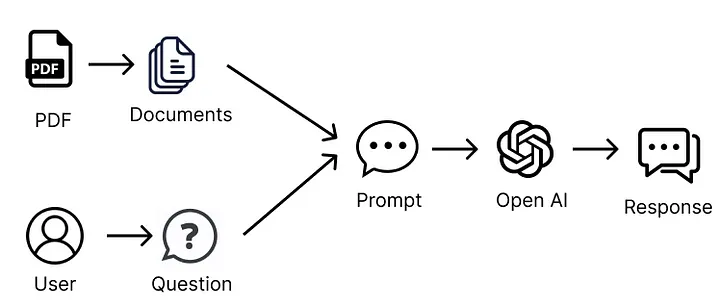)

In [ ]:
#https://www.kap.org.tr/tr/sirket-bilgileri/ozet/5861-ebebek-magazacilik-a-s

In [ ]:
#PDF indirme fonksiyonu

import requests

def download_file(url, file_name, headers):
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        with open(file_name, "wb") as f:
            f.write(response.content)
    else:
        print(response.status_code)

headers = {"User-Agent": "Chrome/51.0.2704.103",}

url = "https://www.kap.org.tr/tr/BildirimPdf/1192434"

file_name = "ebebek_kap_bildirim.pdf"

download_file(url, file_name, headers)

In [ ]:
#!pip install pypdf

In [ ]:
import os
from langchain.document_loaders import PyPDFLoader

pdf_loader = PyPDFLoader('/content/ebebek_kap_bildirim.pdf')
documents = pdf_loader.load()
documents

In [ ]:
from langchain.llms import OpenAI
from langchain.chains.question_answering import load_qa_chain

# we are specifying that OpenAI is the LLM that we want to use in our chain
chain = load_qa_chain(llm=OpenAI())
#query = 'Hissenin baz fiyatı ne kadardır?'
query = 'EBEBK hangi gün işlem görmeye başlayacak?'

response = chain.run(input_documents=documents, question=query)
print(response)

## csv'ye soru sormak - (Transfermarkt Premier Lig Dataset)

In [ ]:
#CSV indirme fonksiyonu

url = "https://raw.githubusercontent.com/ewenme/transfers/master/data/premier-league.csv"
file_name= "transfermarkt.csv"

download_file(url, file_name, headers)

In [ ]:
import pandas as pd

from langchain.agents import create_csv_agent
from langchain.llms import OpenAI

llm=OpenAI(temperature=0,verbose=True)
agent = create_csv_agent(llm, '/content/transfermarkt.csv', verbose=True)

df = pd.read_csv('/content/transfermarkt.csv')
df

In [ ]:
agent

In [ ]:
agent.agent.llm_chain.prompt.template

In [ ]:
agent.run("Find the oldest and youngest players. Give brief summary about them.")

## db'ye SQL Sorgusu Atmak - (titanic sql database)

In [ ]:
from langchain import OpenAI

from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.sql_database import SQLDatabase
from langchain.llms.openai import OpenAI
from langchain.agents import AgentExecutor
from langchain.agents.agent_types import AgentType
from langchain.chat_models import ChatOpenAI

#SQLdb indirme fonksiyonu
url = "https://github.com/brunogarcia/langchain-titanic-sqlite/raw/main/titanic.db"
file_name= "titanic.db"
download_file(url, file_name, headers)

db = SQLDatabase.from_uri("sqlite:///titanic.db")
toolkit = SQLDatabaseToolkit(db=db, llm=OpenAI(temperature=0))

agent_executor = create_sql_agent(
    llm=OpenAI(temperature=0),
    toolkit=toolkit,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

agent_executor.run("How many passengers were in each class?")

# How many passengers survived?
# What was the average age of each passenger class?

#Python kodu oluşturma ve çalıştırma

In [ ]:
import os
from langchain.llms.openai import OpenAI
from langchain.agents.agent_types import AgentType
from langchain.agents.agent_toolkits import create_python_agent
from langchain.tools.python.tool import PythonREPLTool
from langchain.python import PythonREPL


agent_executor = create_python_agent(
    llm=OpenAI(temperature=0.5, max_tokens=1000),
    tool=PythonREPLTool(),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

agent_executor.run("Build me a simple pomodoro app and run it.")

#Write a function to check if 119 a prime number and test it.

# Wikipedia/DuckDuckGo Search ile araştırma yapmak (part-1)


In [ ]:
#!pip install duckduckgo-search

In [ ]:
from langchain import OpenAI
from langchain.tools import DuckDuckGoSearchRun
from langchain.agents import initialize_agent
from langchain.agents import Tool

llm = OpenAI(temperature=0)

search = DuckDuckGoSearchRun()

duckduckgo_tool = Tool(
    name='DuckDuckGo Search',
    func= search.run,
    description="Useful for when you need to do a search on the internet to find information that another tool can't find."
)

tools = [duckduckgo_tool]

search_agent = initialize_agent(
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=3,
)

search_agent.run("What is the total number of commits in langchain repository in Github?")
#what Arxiv is and what fields it is used in?

# Arxiv üzerinden araştırma yapmak (part-2)


In [ ]:
#!pip install arxiv

In [ ]:
import os
from langchain.agents import load_tools, initialize_agent, AgentType

llm = OpenAI(temperature=0)
tools = load_tools(
    ["arxiv"]
)

agent_chain = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
)

agent_chain.run(
    "What is RLHF?",
)

# What's the paper 1706.03762 about?"
# https://arxiv.org/abs/1706.03762

# Youtube Arama Toolu

In [ ]:
pip install youtube_search

In [ ]:
import os
from langchain.llms import OpenAI
from langchain.tools import YouTubeSearchTool
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType

#langchain.debug = False

tool = YouTubeSearchTool()

tools = [
    Tool(
        name="Search",
        func=tool.run,
        description="useful for when you need to give links to youtube videos. Remember to put https://youtube.com/ in front of every link to complete it",
    )
]

agent = initialize_agent(
    tools,
    OpenAI(temperature=0),
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=False,
)

agent.run('langchain official page videos,3')

#Kendi fonksiyonlarınızı yazarak Tool olarak kullanmak

In [ ]:
import os
from langchain import OpenAI
from langchain.agents import initialize_agent, AgentType,Tool

def carpim_islemi(a, b):
    return a * b

def parse_carpim_islemi(string):
    a, b = string.split(",")
    return carpim_islemi(int(a), int(b))


llm = OpenAI(temperature=0)
tools = [
    Tool(
        name="Multiplier",
        func=parse_carpim_islemi,
        description="useful for when you need to multiply two numbers together. The input to this tool should be a comma separated list of numbers of length two, representing the two numbers you want to multiply together. For example, `1,2` would be the input if you wanted to multiply 1 by 2.",
    )
]
agent = initialize_agent(
    tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)

agent.run("33,99")

#Unofficial olarak ChatGPT AI Pluginleri kullanmak - Etihad Airways Flight Search

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.agents import load_tools, initialize_agent, AgentType
from langchain.tools import AIPluginTool
import langchain

langchain.debug=True
langchain.verbose=True
def initialize_chat_agent():
    # Load language model
    chat_model = ChatOpenAI(temperature=0, max_tokens=2048,verbose=True)

    # Load required tools
    tool = AIPluginTool.from_plugin_url("https://gpt-etihad.botim.me/.well-known/ai-plugin.json")
    tools = load_tools(["requests_all"]) + [tool]

    # Initialize chat agent chain
    agent_chain = initialize_agent(tools, chat_model, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)

    return agent_chain

agent_chain = initialize_chat_agent()

query = "Search flights from IST to AUH on 11 December 2023."
agent_chain.run(query)

# LLM ile komut satırı arayüzü(cmd) çalıştırmak

In [ ]:
import os
from langchain.chat_models import ChatOpenAI
from langchain.agents import AgentType
from langchain.tools import ShellTool,PythonREPLTool
from langchain.agents import initialize_agent

llm = ChatOpenAI(temperature=0)

shell_tool = ShellTool()
pythonrepl_tool = PythonREPLTool()

shell_tool.description = shell_tool.description + f"args {shell_tool.args}".replace(
    "{", "{{"
).replace("}", "}}")

agent = initialize_agent(
    [shell_tool,pythonrepl_tool], llm, agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION, verbose=True
)

agent.run(
    "create a .txt file called model_trainer and inside it, add code that trains a basic convolutional neural network for 4 epochs"
)

#rename .txt file called model_trainer into cnn_trainer

#build a pomodoro app in python"

In [ ]:
LangSmith
https://smith.langchain.com/

#Build and deploy LLM apps with confidence
#An all-in-one developer platform for every step of the application lifecycle.

#Use the invite code `lang_learners_2023`